Скачивание w8a...
Успешно скачано: w8a

Обработка w8a: m=49749, n=300, λ=0.0000


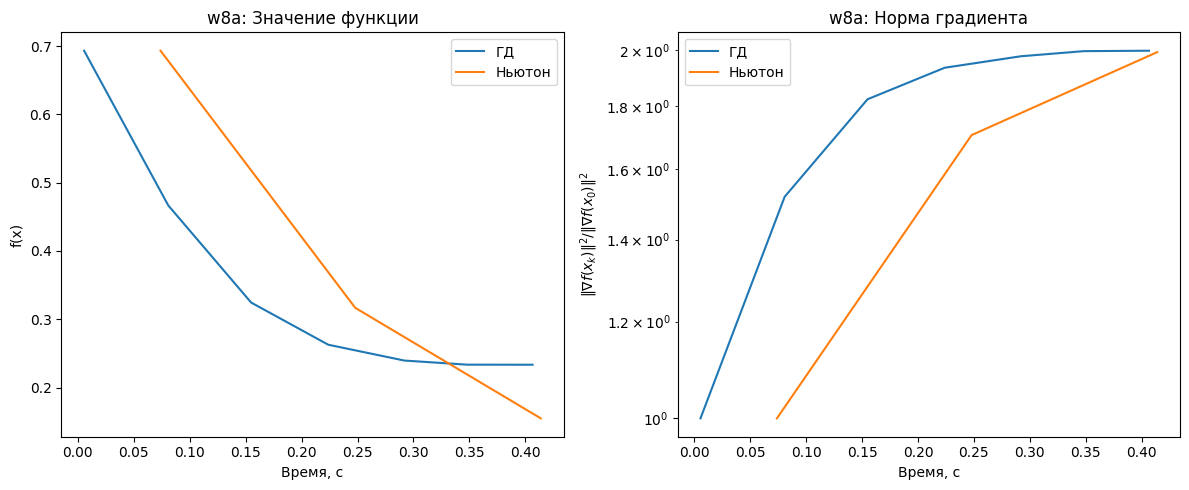

Неизвестный датасет: gisette
Не удалось загрузить ['w8a', 'gisette', 'real-sim'], пропускаем...
Скачивание real-sim...
Успешно скачано: real-sim
Ошибка при загрузке real-sim: could not convert string to float: b'BZh91AY&SY\x08\xdbn\x95\x01\x8a\xa8\xd8\x00p\x10@\x01\x7f\xf0g\x8a\x1fi\xea-\xe7Ym6\xd6\x9d\x8c\xed[Z\xdb[\xee\xea\xebOl\x8e\xb4\xd6\xda\xc6\xae\xee\xe5FV6\xd1\xbd\x07]\xb5fg\xb9\xaeQ%\xb5\xb5\x13;s\xa1mm\xae\xee\xdc\xd1]\xb6\xd8*\xdb\xb9\xbbb\xba:q*\xa8eF\xe4gR\xed\x8e\xa84\xab\xb6\x8e\xa7\xb3N\xdav\xd5sb\xac\xd92\x85^\xedT\xbbak\xb1\xdbnm\xb4\xb5\xa1{\xb1\xdec\xa1r\xdd\x86\xb9\xb4\xda\xdbf\xd6\xd6\xaa\xa8\xaa\xf6\xcb\xacd{\xb3\xac\xa0\xd9\xb6\x17n\xb9\x9bGZK\xa9\xafs\xae\xf7p\xeb5\x8dj\xd51R\xd1m\xb66\xab\x02\x9a%\x1bu\xc9\xdb\x08\xb2s7-\xb3jmi\xb7\xb9\xd7Vm3ZZ%-\xac\xa06\xda\xd0ow:Z\xdal\xb6\xb2Y\x89:\\\xd2\xbbPkf\xd99\xd2\xcb];\xbbw\\\\\xda\xbe\xee\xee\xf7=F\xce\xafy\xde\xbb\xd7n{\xb7;f\xfa\xf7\xab\xee\xdfr\xf7\xbaoozv\xe6\xab\xbd\xe3\xbb\xdf|\xde\x9fdi\x9a\xbe\xb5\xf7w\xde

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from sklearn.datasets import load_svmlight_file
import tempfile
import time
from optimization import gradient_descent, newton
from oracles import create_log_reg_oracle

# Функция для скачивания датасета в формате LIBSVM
def download_libsvm_dataset(dataset_name):
    """
    Скачивает датасет с LIBSVM и возвращает данные
    """
    # URLs для скачивания
    urls = {
        'w8a': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a',
        'w8a.t': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a.t',
        'gisette_scale': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2',
        'real-sim': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2'
    }

    if dataset_name not in urls:
        print(f"Неизвестный датасет: {dataset_name}")
        return None, None

    url = urls[dataset_name]

    try:
        # Создаем временный файл
        with tempfile.NamedTemporaryFile(delete=False, suffix='.libsvm') as tmp_file:
            tmp_path = tmp_file.name

        print(f"Скачивание {dataset_name}...")

        # Скачиваем файл
        urllib.request.urlretrieve(url, tmp_path)
        print(f"Успешно скачано: {dataset_name}")

        # Загружаем данные
        A, b = load_svmlight_file(tmp_path)

        # Преобразуем метки в {-1, +1}
        b = np.where(b > 0, 1, -1)

        # Удаляем временный файл
        os.unlink(tmp_path)

        return A, b
    except Exception as e:
        print(f"Ошибка при загрузке {dataset_name}: {e}")
        # Пытаемся удалить временный файл в случае ошибки
        try:
            os.unlink(tmp_path)
        except:
            pass
        return None, None

# Основной запуск
datasets = ['w8a', 'gisette', 'real-sim']
results = {}

for name in datasets:
    # Загружаем данные
    A, b = download_libsvm_dataset(name)
    if A is None:
            print(f"Не удалось загрузить {datasets}, пропускаем...")
            continue
    # Получаем размерность данных
    m, n = A.shape
    # Регуляризационный коэффициент
    regcoef = 1/m
    print(f"\nОбработка {name}: m={m}, n={n}, λ={regcoef:.4f}")
    # Создаем оракул функции логистической регрессии
    oracle = create_log_reg_oracle(A, b, regcoef)

    x0 = np.zeros(n)

    # Запуск градиентного спуска
    t0 = time.time()
    x_gd, _,  hist_gd = gradient_descent(
                    oracle, x0,
                    tolerance=1e-4,
                    max_iter=1000,
                    line_search_options=None,  # Передаем параметры поиска шага
                    trace=True,               # Включаем трассировку (запись истории)
                    display=False
                )
    t_gd = time.time() - t0

    # Запуск метода Ньютона (если размерность позволяет)
    t_nt = None
    hist_nt = None
    if n <= 2000:
        t0 = time.time()
        x_nt, _, hist_nt = newton(
                oracle, x0,
                tolerance=1e-4,
                max_iter=50,
                line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9},
                trace=True,
                display=False
            )
        t_nt = time.time() - t0
    else:
        print("Пропуск метода Ньютона из-за большой размерности.")

    results[name] = {
        'gd': {'history': hist_gd, 'time': t_gd},
        'newton': {'history': hist_nt, 'time': t_nt} if hist_nt else None,
        'm': m,
        'n': n
    }

    # Построение графиков
    plt.figure(figsize=(12,5))
    # Значение функции
    plt.subplot(1,2,1)
    plt.plot(hist_gd['time'], hist_gd['func'], label='ГД')
    if hist_nt:
        plt.plot(hist_nt['time'], hist_nt['func'], label='Ньютон')
    plt.xlabel('Время, с')
    plt.ylabel('f(x)')
    plt.title(f'{name}: Значение функции')
    plt.legend()

    # Нормаль градиента
    plt.subplot(1,2,2)
    init_grad_norm = hist_gd['grad_norm'][0]
    plt.semilogy(hist_gd['time'], np.array(hist_gd['grad_norm'])/init_grad_norm, label='ГД')
    if hist_nt:
        init_grad_norm_nt = hist_nt['grad_norm'][0]
        plt.semilogy(hist_nt['time'], np.array(hist_nt['grad_norm'])/init_grad_norm_nt, label='Ньютон')
    plt.xlabel('Время, с')
    plt.ylabel(r'$‖∇f(x_k)‖^2 / ‖∇f(x_0)‖^2$')
    plt.title(f'{name}: Норма градиента')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Итоги
print("\nИТОГИ:")
for name, res in results.items():
    print(f"\n{name} (m={res['m']}, n={res['n']}):")
    print(f"Градиентный спуск: {res['gd']['time']:.2f} сек")
    if res['newton']:
        print(f"Ньютон: {res['newton']['time']:.2f} сек")
    else:
        print("Ньютон: пропущен из-за большой размерности.")

print("\nВыводы:")
print("1) На малых данных Ньютон быстрее, так как использует гессиан.")
print("2) На больших данных Градиентный спуск предпочтительнее из-за затрат на хранение и вычисление гессиана.")
print("3) Стоимость итерации: ГД — O(mn), Ньютон — O(mn^2 + n^3).")
print("4) Память: ГД — O(mn), Ньютон — O(mn + n^2).")

Описание левого графика:
График значения функции f(xk) (по оси y) в зависимости от времени выполнения (по оси x) для методов градиентного спуска (ГД) и метода Ньютона.

Оба метода показывают снижение значения функции со временем, что свидетельствует о сходе к минимуму.
График метода Ньютона (оранжевая линия) убывает быстрее, достигая меньших значений функции за меньшее время, что говорит о его большей эффективности на данном этапе.
Градиентный спуск (синяя линия) уменьшает значение функции медленнее, особенно на начальных этапах.

Вывод:
Метод Ньютона более быстро уменьшает значение функции, что характерно для методов, использующих гессиан, особенно на малых и средних задачах.

Описание правого графика: Нормы градиента (по оси y, логарифмическая шкала) в зависимости от времени (по оси x).
  
Нормы градиента уменьшаются для обоих методов, что говорит о приближении к оптимуму.
График метода Ньютона (оранжевая линия) показывает более быстрое снижение нормы градиента по сравнению с градиентным спуском, что указывает на более эффективное приближение к точке минимума.

В начале оба метода имеют одинаковую норму градиента (при времени 0), затем Ньютон ускоряет снижение.

Вывод:
Метод Ньютона достигает более быстрого уменьшения градиента, что говорит о более высокой скорости сходимости.